In [1]:
import os, sys, random, copy, json
import numpy as np
import cv2
import imutils
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, Dropout, 
                                     Flatten, MaxPooling2D)
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append('../')

### Load Data

In [16]:
from utils.utils import makeMini, myPlot, answerToPoints, meanTruth, newVals, iterMean
from scorer_scripts_v2.scorer_scripts_v2.score_detections import score
from starter_scripts_v2.starter_scripts_v2.helper import plot_bbox

from utils.misc import contrivedLabel, plotLabel, summaryStats, bagData
from models.model import ModelBuilder
from models.data import DataXPrep, DataYPrep

In [103]:
p_truth = '../truth_new.json'
with open(p_truth, 'r') as f:
    truth = json.load(f)
list(truth.items())[:3]

[('IMG_9622.JPG', [[583, 439, 772, 431, 779, 628, 582, 631]]),
 ('IMG_9925.JPG', [[481, 295, 769, 268, 777, 590, 480, 589]]),
 ('IMG_6733.JPG', [[593, 362, 650, 399, 649, 597, 589, 592]])]

In [7]:
truth_0 = {}
for k in truth.keys():
    if len(truth[k][0]) > 0:
        truth_0[k] = truth[k][0][0]

truth_1 = {}
for k in truth.keys():
    if len(truth[k][0]) > 0:
        truth_1[k] = truth[k][0][1]
        
print (list(truth_0.items())[:3], '\n', list(truth_1.items())[:3])

[('IMG_9622.JPG', 583), ('IMG_9925.JPG', 481), ('IMG_6733.JPG', 593)] 
 [('IMG_9622.JPG', 439), ('IMG_9925.JPG', 295), ('IMG_6733.JPG', 362)]


In [8]:
p_training = '../Data_Training/Data_Training/'
def loadImg(fn):
    return cv2.imread(p_training + fn)

### Build Dataset

In [14]:
random.seed(a=0, version=2)
N = 500
batch = random.sample(list(truth_0.keys()), N)  # use truth_0 with no missing rects

In [144]:
x_load = [loadImg(k) for k in batch]

y0_load = [truth_0[k] for k in batch]
y1_load = [truth_1[k] for k in batch]

In [61]:
from models.data import DataXPrep, DataYPrep

In [62]:
yPrep = DataYPrep()

In [145]:
y0 = yPrep.normData_static(y0_load)
y1 = yPrep.normData_static(y1_load)

In [64]:
xPrep = DataXPrep(data=x_load)

In [65]:
xPrep.buildDataT(
               b_resize=True,
               resize_width=108,
               b_cvt_grayscale=False
              )
x_t = xPrep.getDataT()
input_shape = xPrep.getImgTShape()

### Build Model

In [72]:
mb = ModelBuilder()

In [73]:
mb.setInputShape(input_shape)

In [74]:
mb.buildModel()

In [75]:
mb.fitModel(x=x_t, y=y0, epochs=10, validation_split=0.5)

Train on 250 samples, validate on 250 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
250/250 [==============================] - 3s 11ms/sample - loss: 64498624.1865 - mean_absolute_error: 3120.2805 - mean_squared_error: 64498624.0000 - val_loss: 24327.9866 - val_mean_absolute_error: 122.4267 - val_mean_squared_error: 24327.9863
Epoch 2/10
250/250 [==============================] - 3s 10ms/sample - loss: 79426.4841 - mean_absolute_error: 225.3047 - mean_squared_error: 79426.4766 - val_loss: 85320.1197 - val_mean_absolute_error: 276.5387 - val_mean_squared_error: 85320.1250
Epoch 3/10
250/250 [==============================] - 3s 10ms/sample - loss: 94483.5985 - mean_absolute_error: 242.8831 - mean_squared_error: 94483.6016 - val_loss: 92016.9803 - val_mean_absolute_error: 289.2223 - val_mean_squared_error: 92016.9844
Epoch 4/10
250/250 [==============================] - 3s 11ms/sample - loss: 62033.3470 - mean_absolute_error: 203.5666 - mean_squared_error: 62033.3477

### Load Previous Models

In [93]:
p_batch = '../models/model_data/batch_y0y1.txt'
with open(p_batch, 'r') as f:
    lines = f.readlines()
index_prev = [str.strip(s) for s in lines]

In [94]:
p_model = '../models/model_data/model_y0.h5'
model_y0 = keras.models.load_model(p_model)

p_model = '../models/model_data/model_y1.h5'
model_y1 = keras.models.load_model(p_model)

##### Pref on Training Set

In [98]:
x_prev = [loadImg(fn) for fn in index_prev]
xPrep_2 = DataXPrep(data=x_prev)
xPrep_2.buildDataT(b_resize=True, resize_width=108)
x_prev_t = xPrep_2.getDataT()

In [106]:
truth_training = [truth[ind][0][y_ind] for ind in index_prev]

In [108]:
predicted_training = model_y0.predict(x=x_prev_t)

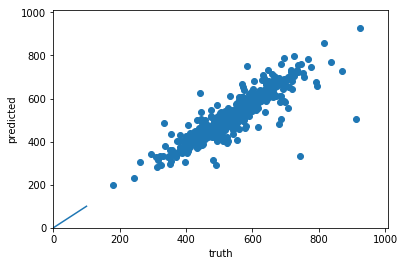

In [109]:
mb.plotPredVsActual(truth_training, predicted_training)

In [112]:
mb.eval(model_y0, x=x_prev_t, y=truth_training)

[3026.51091796875, 37.42433, 3026.511]

##### Perf on Test Set

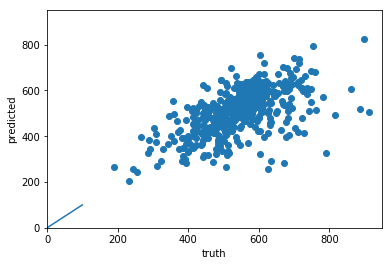

In [110]:
truth_test = y0_load
predicted_test = model_y0.predict(x=x_t)
mb.plotPredVsActual(truth_test, predicted_test)

In [113]:
mb.eval(model_y0, x=x_t, y=truth_test)

[9223.4623828125, 67.67315, 9223.461]

In [114]:
summaryStats(truth_test)

mean y      : 543.73
mean abs err: 78.53
mean sq err:  10527.56


OK, so it's 20% less than baseline (y=mean(y)) error

### Build Cartesian Distance

In [146]:
pred_x = model_y0.predict(x_t)
pred_y = model_y1.predict(x_t)

pred_points = [(int(a[0]),int(b[0])) for a,b in zip(pred_x, pred_y)]

In [148]:
#build the mean
truth_points = [(a,b) for a,b in zip(y0_load, y1_load)]

In [132]:
from utils.misc import plotLabel

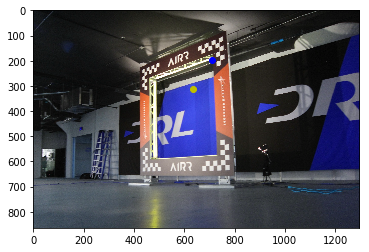

In [153]:
ind = 10
img = x_load[ind]
plotLabel(img = img, b_cvt=False, point=truth_points[ind],
         point_pred=pred_points[ind])

In [174]:
cart_distance = [ float( ((t[0] - pred_x)**2 + (t[1] - pred_y)**2)**(0.5)) 
                 for t, pred_x, pred_y in zip(truth_points, pred_x, pred_y)
                ]

In [178]:
mean_point = (sum([t[0] for t in truth_points]) / len(truth_points),
              sum([t[1] for t in truth_points]) / len(truth_points)
             )

In [184]:
mean_point

(543.734, 338.382)

In [185]:
mean_x = [int(mean_point[0]) for x in truth_points]
mean_y = [int(mean_point[1]) for x in truth_points]

In [186]:
cart_mean = [ float( ((t[0] - pred_x)**2 + (t[1] - pred_y)**2)**(0.5)) 
                 for t, pred_x, pred_y in zip(truth_points, mean_x, mean_y)
                ]

In [192]:
print('mean (sum of distance) : %i' % int(sum(cart_mean)))
print('model (sum of distance): %i' % int(sum(cart_distance)))

mean (sum of distance) : 56304
model (sum of distance): 43865


Good stuff: we've improved error 20% from avg-baseline.
    
Some of the plots below look quite accurate

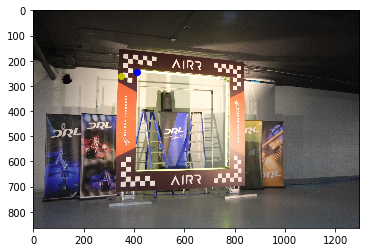

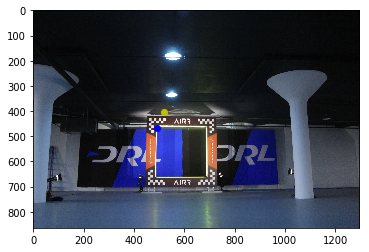

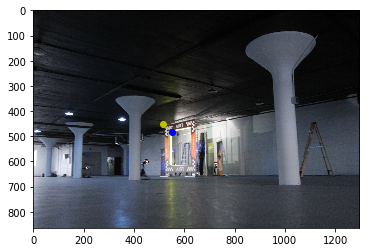

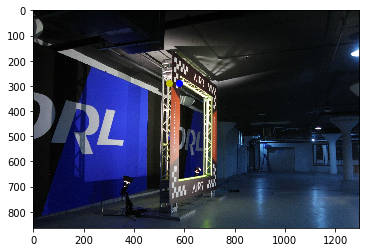

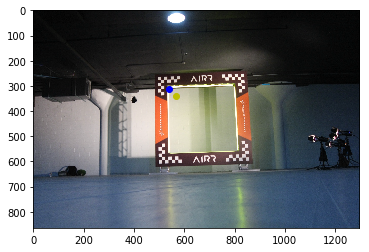

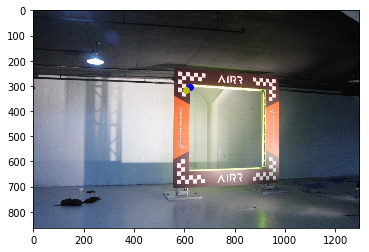

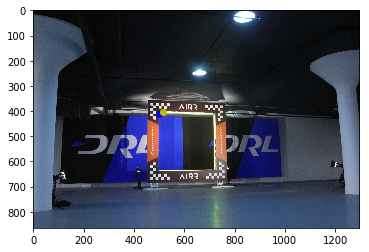

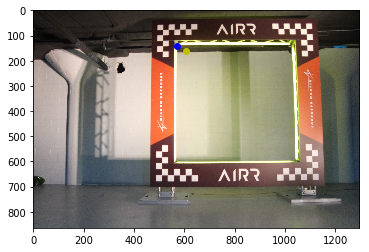

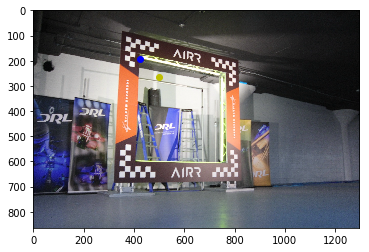

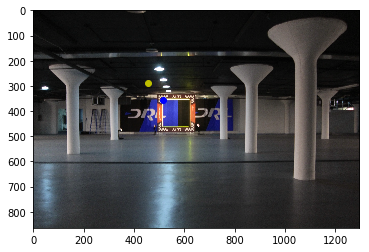

In [193]:
N=10
for ind in random.sample(range(len(truth_points)), N):
    img = x_load[ind]
    plotLabel(img = img, b_cvt=False, point=truth_points[ind],
             point_pred=pred_points[ind])